# A Comprehensive Twitter US Airline Sentiment Analysis


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
#from plotnine import ggplot, aes, geom_line
#from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from textblob.classifiers import NaiveBayesClassifier
%matplotlib inline

In [26]:
plt.figure(figsize=(12,9));

<Figure size 864x648 with 0 Axes>

In [4]:
df = pd.read_csv('../Datasets/Tweets.csv')
df.sample(4)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1122,569920661642088448,negative,1.0,Can't Tell,0.6732,United,NaN,_mhertz,NaN,1,@united you're the reason this whole travel ex...,NaN,2015-02-23 10:04:09 -0800,NaN,Pacific Time (US & Canada)
9176,570083548364992512,negative,1.0,Customer Service Issue,1.0000,US Airways,NaN,worldwideweg,NaN,0,@usairways - It's all automated and no one car...,NaN,2015-02-23 20:51:24 -0800,NaN,NaN
2713,568946758404808704,positive,1.0,NaN,NaN,United,NaN,nfriesen1,NaN,0,@united she's the type of person that can make...,NaN,2015-02-20 17:34:12 -0800,"Winnipeg, MB Canada",Central Time (US & Canada)
2440,569206925046493184,negative,1.0,Can't Tell,0.6723,United,NaN,aushianya,NaN,0,@united I interviewed yesterday as a flight at...,NaN,2015-02-21 10:48:00 -0800,NaN,NaN


## Exploratory Data Analysis (EDA)

In [5]:
# Some quick infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


Text(0.5, 1.0, 'Summary of Global Sentiment')

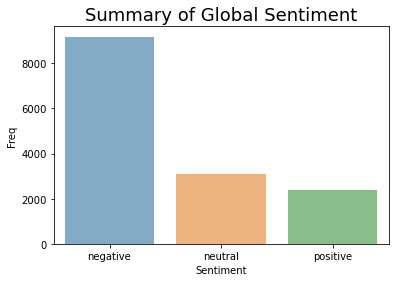

In [27]:
# summary of global sentiment
sns.countplot(x=df['airline_sentiment'].sort_values() , alpha=.6)
plt.ylabel('Freq')
plt.xlabel('Sentiment')
plt.title('Summary of Global Sentiment', fontsize=18)

In [7]:
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [8]:
# Tweets per airline in percent
tweets_per_airline = (df[['airline', 'text']].groupby('airline').count()/len(df['text'].notna().notnull())).sort_values(by='text', ascending=False)
tweets_per_airline

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


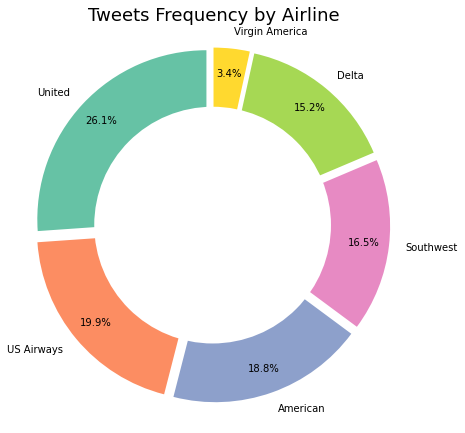

In [28]:
 
# Pie Chart of normalized tweets frequency for each airline
# Although, it is not recommended to use pie chart as visualization, 
# since they could be confusing and hard to understand, it doesn't hurt
# to learn how to do it

#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
colors = sns.color_palette('Set2',10)
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
plt.pie(tweets_per_airline.text, labels=tweets_per_airline.index.values, autopct='%1.1f%%', 
startangle=90, colors=colors,
pctdistance=0.85, explode = [0.05]*tweets_per_airline.shape[0])
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18,);

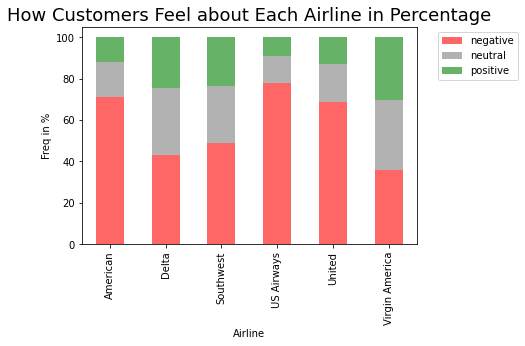

In [29]:
# Plot sentiment rates per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',
                title='How Customers Feel about Each Airline in Percentage', 
                stacked=True,
                color=['red', 'grey', 'green'], alpha=0.6 )

_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Freq in %')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

From the above figure we can already see that Virgin America has the best customer sentiment and US Airways the worst. Indeed, Virgin America was ranked as the second best US airline in the US in 2015 [[1]](https://www.airfarewatchdog.com/blog/23248943/best-u-s-airlines-2015-edition/), while US Airways the 8th or the second worst before United. However, it is important to put those numbers in relation to the total number of customers per carrier for the year 2015. Because what appears to be a large number can, once put into proportion, become really small. So we need to be careful about this kind of  conclusions. 
Nonetheless, knowing that Virgin America was ranked second best in the US in 2015 and best between 2012 and 2014 is a good starting point to understand what makes a good airline from the customer point of view.

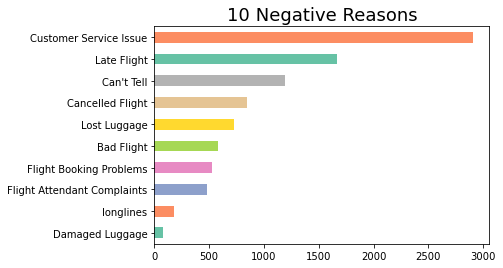

In [32]:
# Let's investigate more  the negative customer sentiments
colors = sns.color_palette('Set2',df['negativereason'].nunique())
df['negativereason'].value_counts().sort_values().plot(kind='barh', color=colors)
plt.title('10 Negative Reasons', fontsize=18,);

There are 10 different reasons for negative reviews. The most important ones are:

1. Customer Service Issue with almost 3000 tweets
2. Late flight (Nr of tweets= 1665)
3. Can't tell, which means the overall flight experience with more than 1100 tweets.

Showing this kind of graph is all well and good, but it is important to connect each of these sources of negative reactions to the value chain of the company in question in order to determine the actions that need to be taken to increase customer satisfaction. 
After all, this kind of analysis only makes sense if it leads to effective actions.

In [35]:
neg_rev.columns

Index(['Delta', 'US Airways', 'Virgin America'], dtype='object')

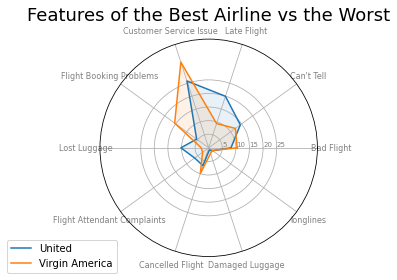

In [46]:
# Plot a radar chart with the negative reasons for three carriers
# Generate a dataframe with negative reasons rates per carrier for 3 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in ['United', 'Virgin America']:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

# number of variable
categories = list(neg_rev.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values


# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=7)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1.5, linestyle='solid', label=label)
# Fill area
ax.fill(angles, values, ['b', 'o', 'green'], alpha=0.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)

plt.title('Features of the Best Airline vs the Worst', fontsize=18,);
# Show the graph
plt.show()

It seems that travelers give much more importance to flight delays and lost luggages than to technical problems during online ticket booking.So to compete with best airline companies havee to improve thooses both variable.

So let's compare virgin america with delta, which is ranked as the third best and comes exactly after virgin for overall performance 


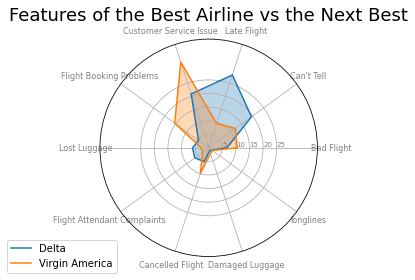

In [50]:
# Plot a radar chart with the negative reasons for three carriers
# Generate a dataframe with negative reasons rates per carrier for 3 carriers
neg_rev = pd.DataFrame(index=df['negativereason'].dropna().unique())
for air in ['Delta', 'Virgin America']:
    neg_rev[air] = df[df['airline'] == air]['negativereason'].value_counts(normalize=True)*100

# number of variable
categories = list(neg_rev.index)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# We are going to plot the first column of the data frame.
# But we need to repeat the first value to close the circular graph:
values = neg_rev.values
values = np.append(values, [values[0,:]], axis=0)
labels = neg_rev.columns.values


# Initialise the spider plot
ax = plt.subplot(111, polar=True)
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([5,10,15,20,25], ["5","10","15",'20','25'], color="grey", size=7)
plt.ylim(0,40)
# Plot data
for y_arr, label in zip(values.T, labels):
    ax.plot(angles, y_arr, linewidth=1.5, linestyle='solid', label=label)
# Fill area
ax.fill(angles, values, ['b', 'o', 'green'], alpha=0.3)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1),)

plt.title('Features of the Best Airline vs the Next Best', fontsize=18,);
# Show the graph
plt.show()

The spider graph is an extremely useful benchmarking tool. Just pick the best in class and try to understand their strategy based on customer sentiments. Quite often in the business world it is enough to copy an excellent competitor, to become one yourself, if not to outperform it.

In [75]:
# Generate a workd cloud for negative tweets
tweets = df[df['airline_sentiment']=='negative']
words = ' '.join(tweets['text'])
words_cleaned = re.sub(r'@\S+|https?://\S+', '', words)


In [102]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=400,
                      height=250,
                      collocation_threshold=170,
                      max_words=100,
                     ).generate(words_cleaned)

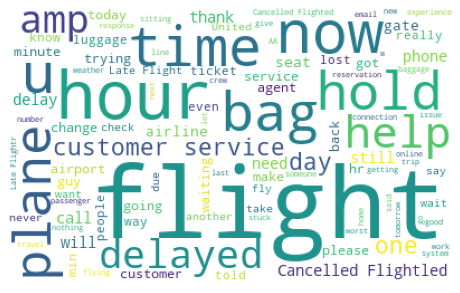

In [104]:
plt.figure(1,figsize=(8, 8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

 The words cloud above validates our initial hypothesis that flight delay is a critical quality indicator in airline rankings. Hower, just analyzing the negative sentiments is only the half of the reality.

However, analyzing negative sentiment is only one facet of the picture. We also need to analyze positive customer sentiments to understand what our benchmark does better and not just what it does less worse. That will not be addressed in this essay as the procedure is the same as before, just the filtering of the information is slightly different.